# STA365: Applied Bayesian Inference HW 8
---
## Question 1

In [1]:
import numpy as np
import pandas as pd
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

In [10]:
df = pd.read_csv("loan_data.csv")

In [11]:
df.head()

,person_age,person_gender,person_income,loan_amnt,loan_int_rate,loan_percent_income,credit_score,loan_status
0,22,female,71948,35000,16.02,0.49,561,1
1,21,female,12282,1000,11.14,0.08,504,0
2,25,female,12438,5500,12.87,0.44,635,1
3,23,female,79753,35000,15.23,0.44,675,1
4,24,male,66135,35000,14.27,0.53,586,1


In [12]:
df = pd.get_dummies(df, columns=['person_gender'], drop_first=True, dtype=int)
scaler = StandardScaler()
cols = df.columns.difference(['person_gender_male','loan_status'])
df[cols] = scaler.fit_transform(df[cols])

In [13]:
df.head()

,person_age,person_income,loan_amnt,loan_int_rate,loan_percent_income,credit_score,loan_status,person_gender_male
0,-0.953538,-0.104090,4.024953,1.683039,4.016394,-1.419814,1,0
1,-1.118963,-0.846005,-1.359209,0.044782,-0.684829,-2.549975,0,0
2,-0.457264,-0.844065,-0.646600,0.625557,3.443074,0.047412,1,0
3,-0.788113,-0.007039,4.024953,1.417829,3.443074,0.840507,1,0
4,-0.622689,-0.176371,4.024953,1.095549,4.475050,-0.924130,1,1


In [14]:
X = df.drop(columns=['loan_status']).values
y = df['loan_status'].values
n,p = X.shape

with pm.Model() as BC:
    
    #Prior
    betas = pm.Normal('betas', mu=0, sigma=1, shape=p)
    
    #Likelihood
    y_obs = pm.Bernoulli('y_obs', p=pm.math.sigmoid(X@betas), observed=y)
    
    #Sample from posterior
    idata = pm.sample(draws=2000,tune=2000, step=pm.Metropolis())

Multiprocess sampling (4 chains in 4 jobs)
Metropolis: [betas]


/opt/conda/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),
/opt/conda/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),
/opt/conda/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),
/opt/conda/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),
Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 1472 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 

In [15]:
az.summary(idata)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
betas[0],0.021,0.012,-0.005,0.041,0.000,0.000,1191.0,1064.0,1.01
betas[1],0.096,0.020,0.058,0.134,0.001,0.000,414.0,643.0,1.01
betas[2],-0.596,0.019,-0.629,-0.558,0.001,0.001,274.0,617.0,1.01
betas[3],0.776,0.013,0.753,0.800,0.000,0.000,1034.0,1104.0,1.01
betas[4],1.206,0.020,1.169,1.242,0.001,0.001,276.0,487.0,1.01
betas[5],-0.016,0.012,-0.038,0.006,0.000,0.000,1308.0,1422.0,1.01
betas[6],-1.593,0.018,-1.624,-1.556,0.001,0.000,1126.0,1169.0,1.01


Observations:
- Chains are well mixed (within and between; $\hat R \approx 1$) and all appear to have converged
- effective sample size is reasonably high ($\beta_1$, $\beta_2$, and $\beta_4$ are a bit low)

Based on the posterior samples...
- Being male ($\beta_6$) decreases the log odds of being approved by 1.592
- Loan percent income ($\beta_4$) has the greatest positive effect on the log odds of loan approval
    - intuitively you would expect the opposite effect
    - however its ess is rather low, so the estimate may be unreliable
- The higher the loan interest rate ($\beta_3$), the higher log odds of approval
- The lower the loan amount ($\beta_2$), the higher the log odds of approval


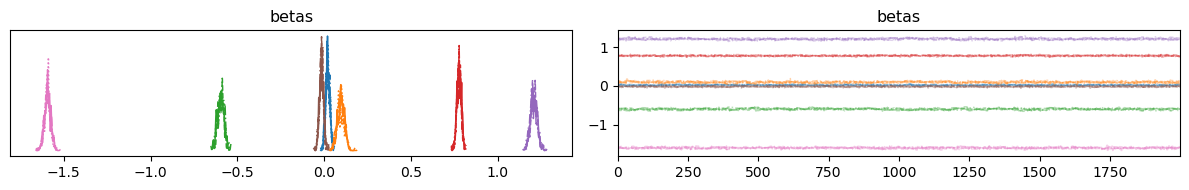

In [16]:
az.plot_trace(idata)
plt.tight_layout()
plt.show()

## Question 2

In [25]:
df = pd.read_csv("housing.csv")
df = df.drop(df[df['total_bedrooms'].isnull()].index)
df.isnull().any()

longitude             False
latitude              False
housing_median_age    False
total_rooms           False
total_bedrooms        False
population            False
households            False
median_income         False
median_house_value    False
dtype: bool

### Effect of n: 50, 100, 500 (m=2, p=7)
- As n increases, the ess goes up and the posterior distribution narrows, suggesting more confidence in the parameter estimates

In [26]:
df2 = df.sample(50, random_state=1)

In [27]:
X = df2.drop(columns=['housing_median_age', 'median_house_value']).values
Y = df2[['housing_median_age', 'median_house_value']].values

n,p = X.shape
m = Y.shape[1]

with pm.Model() as MNV_LKJ:
    
    packed_L = pm.LKJCholeskyCov("packed_L", n=m, eta=2.0, 
                                 sd_dist=pm.Exponential.dist(1.0, shape=m), 
                                 compute_corr=False)
    L = pm.expand_packed_triangular(m, packed_L)
    betas = pm.Normal('betas', mu=0, sigma=1, shape=(p,m))
    Sigma = pm.Deterministic('Sigma', L.dot(L.T))
    y = pm.MvNormal('y', mu=X@betas, chol=L,  #cov=Sigma
                    observed=Y)   
    
    idata = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [packed_L, betas]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 678 seconds.


In [28]:
az.summary(idata)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
"Sigma[0, 0]",1.506550e+02,27.075,1.034330e+02,2.014470e+02,0.417,0.478,4206.0,3177.0,1.0
"Sigma[0, 1]",-3.591190e+02,2641.600,-5.122303e+03,4.808382e+03,59.093,35.760,1993.0,2923.0,1.0
"Sigma[1, 0]",-3.591190e+02,2641.600,-5.122303e+03,4.808382e+03,59.093,35.760,1993.0,2923.0,1.0
"Sigma[1, 1]",1.274993e+08,1426418.954,1.246115e+08,1.299455e+08,20259.658,23181.569,4963.0,3294.0,1.0
"betas[0, 0]",-2.270000e-01,0.236,-6.460000e-01,2.410000e-01,0.006,0.004,1686.0,2194.0,1.0
"betas[0, 1]",-3.606000e+00,1.007,-5.541000e+00,-1.774000e+00,0.015,0.016,4644.0,2923.0,1.0
"betas[1, 0]",1.960000e-01,0.743,-1.156000e+00,1.585000e+00,0.018,0.011,1741.0,2306.0,1.0
"betas[1, 1]",1.017000e+00,1.016,-8.290000e-01,2.945000e+00,0.015,0.016,4677.0,3040.0,1.0
"betas[2, 0]",-1.000000e-03,0.003,-7.000000e-03,4.000000e-03,0.000,0.000,2664.0,2644.0,1.0
"betas[2, 1]",4.521400e+01,0.601,4.410400e+01,4.634700e+01,0.011,0.008,3041.0,2652.0,1.0


Observations:
- Chains are well mixed (within and between; $\hat R = 1$) and all appear to have converged
- effective sample size is reasonably high for all parameters

Based on the posterior samples...
- Total rooms ($\beta_2$), total bedrooms($\beta_3$), and population ($\beta_4$) have the greatest effect on median house value
    - Intuitively, more rooms and bedrooms raises the property value and higher populations most likely indicate higher demand and higher prices
- Median income ($\beta_6$), and location ($\beta_0$ and $\beta_1$) have the greatest effect on median house age
    - Higher median income is associated with higher median house age (not exactly clear why that is, but perhaps)
    - Higher longitudes (further west) are associated with lower median housing, which may be due to the cities being near the ocean and having more frequent houses being built
    - Conversely, higher latitudes are associated with higher median housing, which may also be due to the cities being near the south

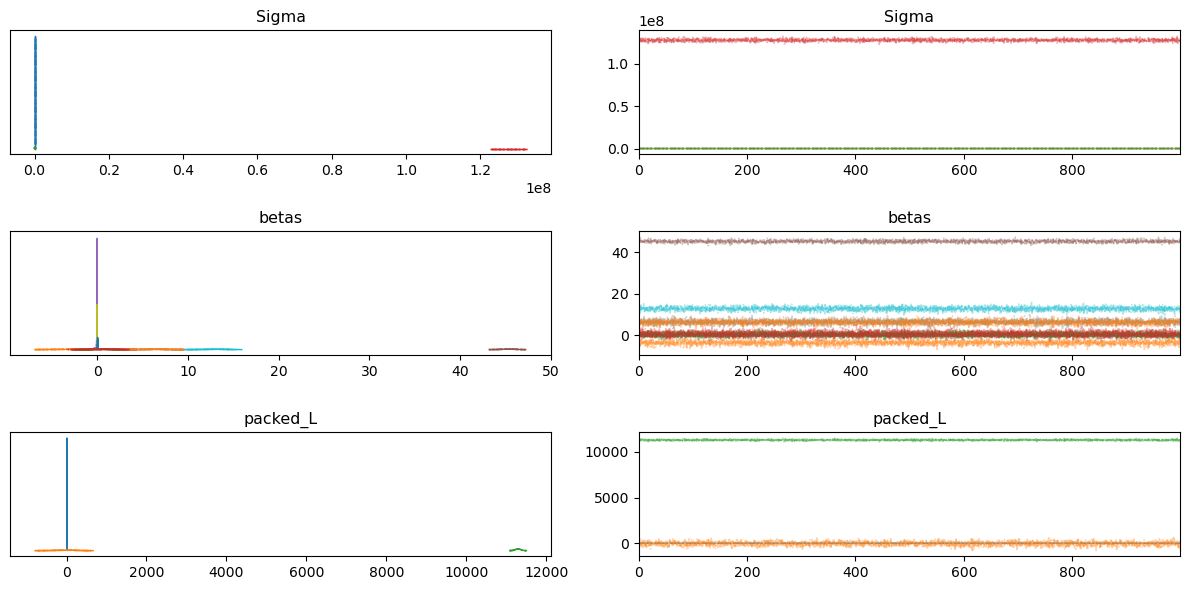

In [29]:
az.plot_trace(idata)
plt.tight_layout()
plt.show()

In [30]:
df2 = df.sample(100, random_state=1)

In [31]:
X = df2.drop(columns=['housing_median_age', 'median_house_value']).values
Y = df2[['housing_median_age', 'median_house_value']].values

n,p = X.shape
m = Y.shape[1]

with pm.Model() as MNV_LKJ:
    
    packed_L = pm.LKJCholeskyCov("packed_L", n=m, eta=2.0, 
                                 sd_dist=pm.Exponential.dist(1.0, shape=m), 
                                 compute_corr=False)
    L = pm.expand_packed_triangular(m, packed_L)
    betas = pm.Normal('betas', mu=0, sigma=1, shape=(p,m))
    Sigma = pm.Deterministic('Sigma', L.dot(L.T))
    y = pm.MvNormal('y', mu=X@betas, chol=L,  #cov=Sigma
                    observed=Y)   
    
    idata = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [packed_L, betas]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1085 seconds.


In [32]:
az.summary(idata)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
"Sigma[0, 0]",1.351590e+02,18.818,1.009890e+02,1.698380e+02,0.293,0.359,4236.0,2608.0,1.0
"Sigma[0, 1]",2.472487e+03,3162.252,-3.067372e+03,8.795534e+03,53.883,46.136,3453.0,2782.0,1.0
"Sigma[1, 0]",2.472487e+03,3162.252,-3.067372e+03,8.795534e+03,53.883,46.136,3453.0,2782.0,1.0
"Sigma[1, 1]",1.954948e+08,1973516.455,1.918847e+08,1.992797e+08,29499.187,35952.693,4504.0,2488.0,1.0
"betas[0, 0]",-2.120000e-01,0.210,-6.170000e-01,1.730000e-01,0.004,0.004,2852.0,2479.0,1.0
"betas[0, 1]",-5.315000e+00,1.013,-7.220000e+00,-3.366000e+00,0.015,0.018,4878.0,2480.0,1.0
"betas[1, 0]",1.280000e-01,0.656,-1.078000e+00,1.397000e+00,0.012,0.012,2899.0,2562.0,1.0
"betas[1, 1]",1.577000e+00,0.974,-2.400000e-01,3.360000e+00,0.015,0.015,4091.0,2749.0,1.0
"betas[2, 0]",-3.000000e-03,0.002,-6.000000e-03,1.000000e-03,0.000,0.000,3515.0,2824.0,1.0
"betas[2, 1]",3.322600e+01,0.532,3.224900e+01,3.424400e+01,0.009,0.008,3522.0,2968.0,1.0


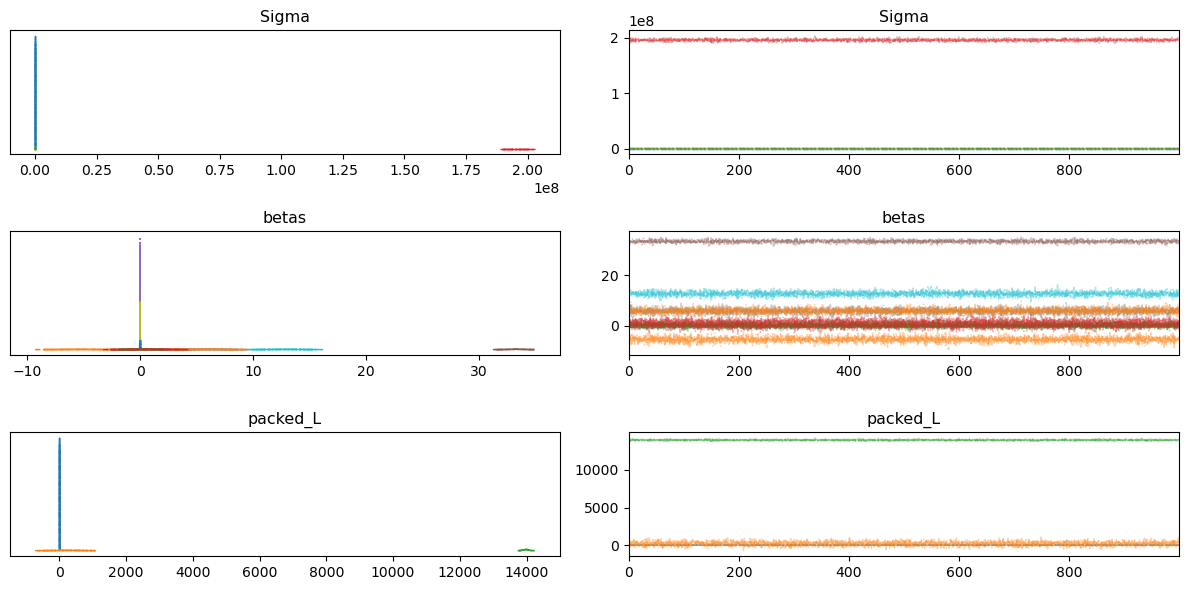

In [33]:
az.plot_trace(idata)
plt.tight_layout()
plt.show()

In [34]:
df2 = df.sample(500, random_state=1)

In [35]:
X = df2.drop(columns=['housing_median_age', 'median_house_value']).values
Y = df2[['housing_median_age', 'median_house_value']].values

n,p = X.shape
m = Y.shape[1]

with pm.Model() as MNV_LKJ:
    
    packed_L = pm.LKJCholeskyCov("packed_L", n=m, eta=2.0, 
                                 sd_dist=pm.Exponential.dist(1.0, shape=m), 
                                 compute_corr=False)
    L = pm.expand_packed_triangular(m, packed_L)
    betas = pm.Normal('betas', mu=0, sigma=1, shape=(p,m))
    Sigma = pm.Deterministic('Sigma', L.dot(L.T))
    y = pm.MvNormal('y', mu=X@betas, chol=L,  #cov=Sigma
                    observed=Y)   
    
    idata = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [packed_L, betas]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1342 seconds.


In [36]:
az.summary(idata)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
"Sigma[0, 0]",1.282280e+02,7.852,1.145980e+02,1.437450e+02,0.107,0.131,5192.0,2575.0,1.0
"Sigma[0, 1]",1.188900e+04,3737.766,4.939506e+03,1.906652e+04,65.747,52.121,3249.0,3165.0,1.0
"Sigma[1, 0]",1.188900e+04,3737.766,4.939506e+03,1.906652e+04,65.747,52.121,3249.0,3165.0,1.0
"Sigma[1, 1]",5.829891e+08,4324439.947,5.748918e+08,5.908204e+08,59680.148,72413.684,5276.0,2865.0,1.0
"betas[0, 0]",-3.870000e-01,0.097,-5.800000e-01,-2.190000e-01,0.002,0.001,2768.0,2894.0,1.0
"betas[0, 1]",-8.935000e+00,0.967,-1.076500e+01,-7.188000e+00,0.014,0.016,4862.0,3029.0,1.0
"betas[1, 0]",-3.000000e-01,0.307,-8.690000e-01,2.610000e-01,0.006,0.005,2824.0,2796.0,1.0
"betas[1, 1]",2.628000e+00,1.004,7.630000e-01,4.524000e+00,0.013,0.018,5748.0,2782.0,1.0
"betas[2, 0]",-0.000000e+00,0.001,-2.000000e-03,1.000000e-03,0.000,0.000,3040.0,2730.0,1.0
"betas[2, 1]",3.535200e+01,0.502,3.439500e+01,3.628400e+01,0.008,0.008,4002.0,3165.0,1.0


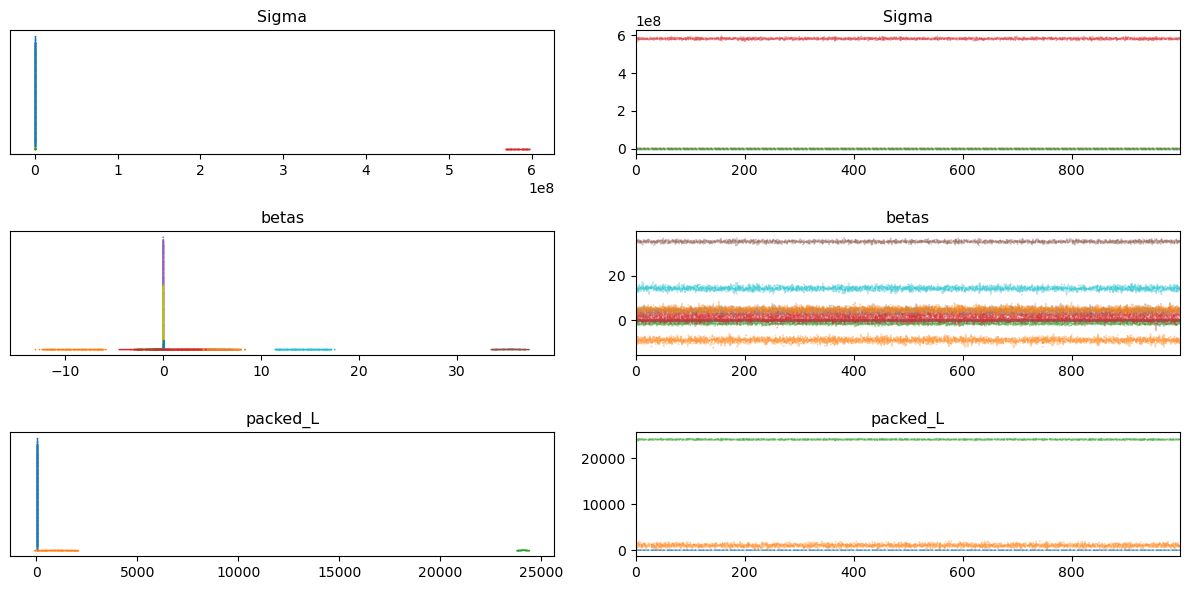

In [37]:
az.plot_trace(idata)
plt.tight_layout()
plt.show()

### Effect of p: 5, 7 (n=100, m=2)
- No noticeable differences

In [38]:
df2 = df.sample(100, random_state=1)

In [39]:
X = df2.drop(columns=['housing_median_age', 'median_house_value', 'longitude', 'latitude']).values
Y = df2[['housing_median_age', 'median_house_value']].values

n,p = X.shape
m = Y.shape[1]

with pm.Model() as MNV_LKJ:
    
    packed_L = pm.LKJCholeskyCov("packed_L", n=m, eta=2.0, 
                                 sd_dist=pm.Exponential.dist(1.0, shape=m), 
                                 compute_corr=False)
    L = pm.expand_packed_triangular(m, packed_L)
    betas = pm.Normal('betas', mu=0, sigma=1, shape=(p,m))
    Sigma = pm.Deterministic('Sigma', L.dot(L.T))
    y = pm.MvNormal('y', mu=X@betas, chol=L,  #cov=Sigma
                    observed=Y)   
    
    idata = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [packed_L, betas]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 565 seconds.


In [40]:
az.summary(idata)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
"Sigma[0, 0]",2.291080e+02,29.105,1.757570e+02,2.830120e+02,0.447,0.526,4357.0,3064.0,1.0
"Sigma[0, 1]",1.603434e+04,3246.975,9.671661e+03,2.186108e+04,61.799,49.020,2753.0,2248.0,1.0
"Sigma[1, 0]",1.603434e+04,3246.975,9.671661e+03,2.186108e+04,61.799,49.020,2753.0,2248.0,1.0
"Sigma[1, 1]",1.959730e+08,1965492.082,1.923271e+08,1.996488e+08,27986.078,29943.825,4921.0,3149.0,1.0
"betas[0, 0]",-7.000000e-03,0.002,-1.100000e-02,-3.000000e-03,0.000,0.000,2859.0,2619.0,1.0
"betas[0, 1]",3.328900e+01,0.543,3.229300e+01,3.430600e+01,0.009,0.008,3418.0,2916.0,1.0
"betas[1, 0]",9.000000e-03,0.021,-2.900000e-02,5.000000e-02,0.000,0.000,2307.0,2489.0,1.0
"betas[1, 1]",5.798000e+00,0.995,3.956000e+00,7.636000e+00,0.015,0.017,4637.0,2976.0,1.0
"betas[2, 0]",1.500000e-02,0.004,8.000000e-03,2.400000e-02,0.000,0.000,2541.0,2733.0,1.0
"betas[2, 1]",1.277500e+01,0.858,1.115600e+01,1.436400e+01,0.014,0.012,3527.0,2878.0,1.0


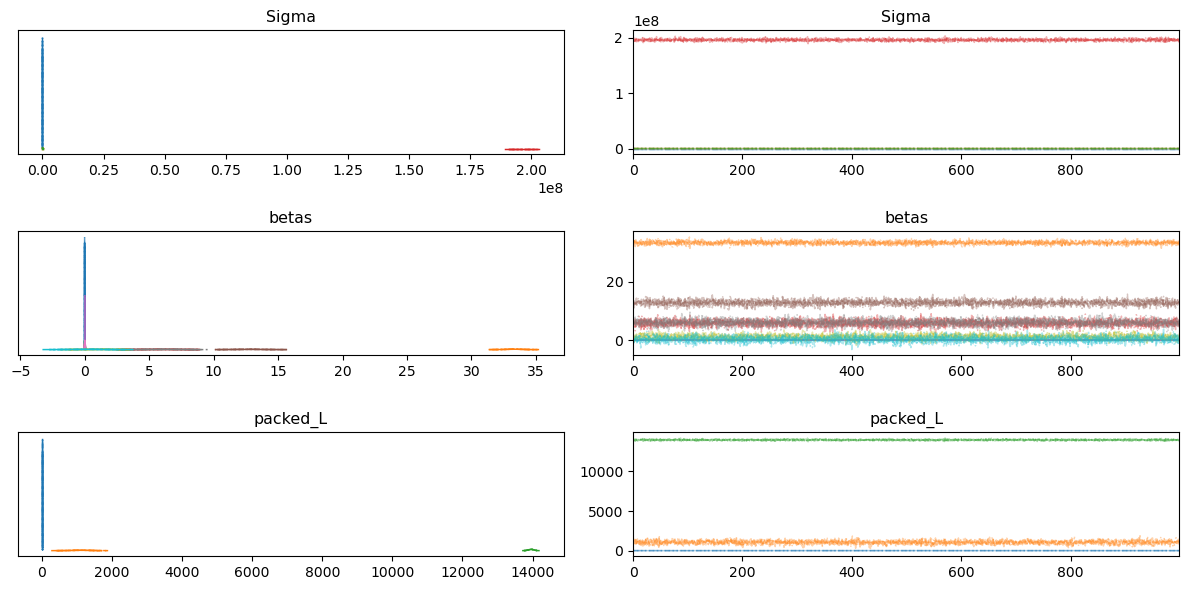

In [41]:
az.plot_trace(idata)
plt.tight_layout()
plt.show()

### Effect of m: 2, 3 (n=100,p=6)
- No noticeable differences

In [42]:
df2 = df.sample(100, random_state=1)

In [43]:
X = df2.drop(columns=['housing_median_age', 'median_house_value', 'median_income']).values
Y = df2[['housing_median_age', 'median_house_value']].values

n,p = X.shape
m = Y.shape[1]

with pm.Model() as MNV_LKJ:
    
    packed_L = pm.LKJCholeskyCov("packed_L", n=m, eta=2.0, 
                                 sd_dist=pm.Exponential.dist(1.0, shape=m), 
                                 compute_corr=False)
    L = pm.expand_packed_triangular(m, packed_L)
    betas = pm.Normal('betas', mu=0, sigma=1, shape=(p,m))
    Sigma = pm.Deterministic('Sigma', L.dot(L.T))
    y = pm.MvNormal('y', mu=X@betas, chol=L,  #cov=Sigma
                    observed=Y)   
    
    idata = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [packed_L, betas]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 901 seconds.


In [44]:
az.summary(idata)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
"Sigma[0, 0]",1.351620e+02,18.446,1.005980e+02,1.694500e+02,0.303,0.293,3753.0,2963.0,1.0
"Sigma[0, 1]",2.954837e+03,2486.746,-1.857566e+03,7.513783e+03,55.873,35.708,1983.0,2662.0,1.0
"Sigma[1, 0]",2.954837e+03,2486.746,-1.857566e+03,7.513783e+03,55.873,35.708,1983.0,2662.0,1.0
"Sigma[1, 1]",1.954345e+08,1871086.191,1.922613e+08,1.993649e+08,29829.052,30272.165,3927.0,2937.0,1.0
"betas[0, 0]",-2.160000e-01,0.198,-5.580000e-01,1.720000e-01,0.005,0.003,1798.0,2359.0,1.0
"betas[0, 1]",-5.300000e+00,0.982,-7.133000e+00,-3.513000e+00,0.016,0.015,3731.0,2826.0,1.0
"betas[1, 0]",1.230000e-01,0.619,-9.740000e-01,1.312000e+00,0.014,0.010,1909.0,2363.0,1.0
"betas[1, 1]",1.552000e+00,1.027,-4.820000e-01,3.345000e+00,0.016,0.017,4129.0,2795.0,1.0
"betas[2, 0]",-3.000000e-03,0.002,-5.000000e-03,0.000000e+00,0.000,0.000,2013.0,2590.0,1.0
"betas[2, 1]",3.323200e+01,0.552,3.217100e+01,3.421900e+01,0.011,0.008,2372.0,2685.0,1.0


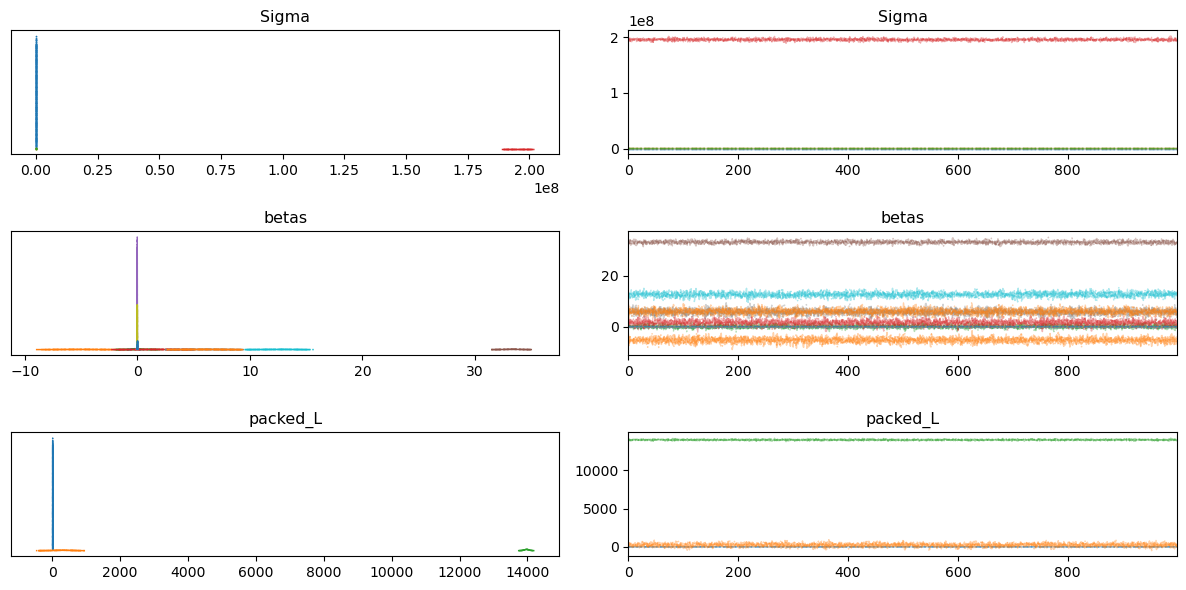

In [45]:
az.plot_trace(idata)
plt.tight_layout()
plt.show()

In [46]:
df2 = df.sample(100, random_state=1)

In [47]:
X = df2.drop(columns=['housing_median_age', 'median_house_value', 'median_income']).values
Y = df2[['housing_median_age', 'median_house_value', 'median_income']].values

n,p = X.shape
m = Y.shape[1]

with pm.Model() as MNV_LKJ:
    
    packed_L = pm.LKJCholeskyCov("packed_L", n=m, eta=2.0, 
                                 sd_dist=pm.Exponential.dist(1.0, shape=m), 
                                 compute_corr=False)
    L = pm.expand_packed_triangular(m, packed_L)
    betas = pm.Normal('betas', mu=0, sigma=1, shape=(p,m))
    Sigma = pm.Deterministic('Sigma', L.dot(L.T))
    y = pm.MvNormal('y', mu=X@betas, chol=L,  #cov=Sigma
                    observed=Y)   
    
    idata = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [packed_L, betas]


/opt/conda/lib/python3.11/site-packages/pytensor/compile/function/types.py:970: RuntimeWarning: invalid value encountered in accumulate
  self.vm()
/opt/conda/lib/python3.11/site-packages/pytensor/compile/function/types.py:970: RuntimeWarning: invalid value encountered in accumulate
  self.vm()
/opt/conda/lib/python3.11/site-packages/pytensor/compile/function/types.py:970: RuntimeWarning: invalid value encountered in accumulate
  self.vm()
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1564 seconds.


In [48]:
az.summary(idata)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
"Sigma[0, 0]",1.357400e+02,18.469,1.012440e+02,1.691550e+02,0.249,0.368,5742.0,2550.0,1.0
"Sigma[0, 1]",3.003448e+03,2531.133,-1.630591e+03,7.903887e+03,44.937,36.654,3179.0,2899.0,1.0
"Sigma[0, 2]",5.240000e-01,1.284,-1.959000e+00,2.862000e+00,0.017,0.024,5652.0,2929.0,1.0
"Sigma[1, 0]",3.003448e+03,2531.133,-1.630591e+03,7.903887e+03,44.937,36.654,3179.0,2899.0,1.0
"Sigma[1, 1]",1.954400e+08,1907547.816,1.919773e+08,1.991593e+08,24079.619,34696.252,6275.0,2920.0,1.0
"Sigma[1, 2]",2.755467e+03,272.161,2.249305e+03,3.272636e+03,5.915,4.553,2121.0,2395.0,1.0
"Sigma[2, 0]",5.240000e-01,1.284,-1.959000e+00,2.862000e+00,0.017,0.024,5652.0,2929.0,1.0
"Sigma[2, 1]",2.755467e+03,272.161,2.249305e+03,3.272636e+03,5.915,4.553,2121.0,2395.0,1.0
"Sigma[2, 2]",1.387000e+00,0.202,1.020000e+00,1.752000e+00,0.003,0.004,5291.0,3088.0,1.0
"betas[0, 0]",-2.160000e-01,0.196,-5.880000e-01,1.440000e-01,0.004,0.003,2399.0,2614.0,1.0


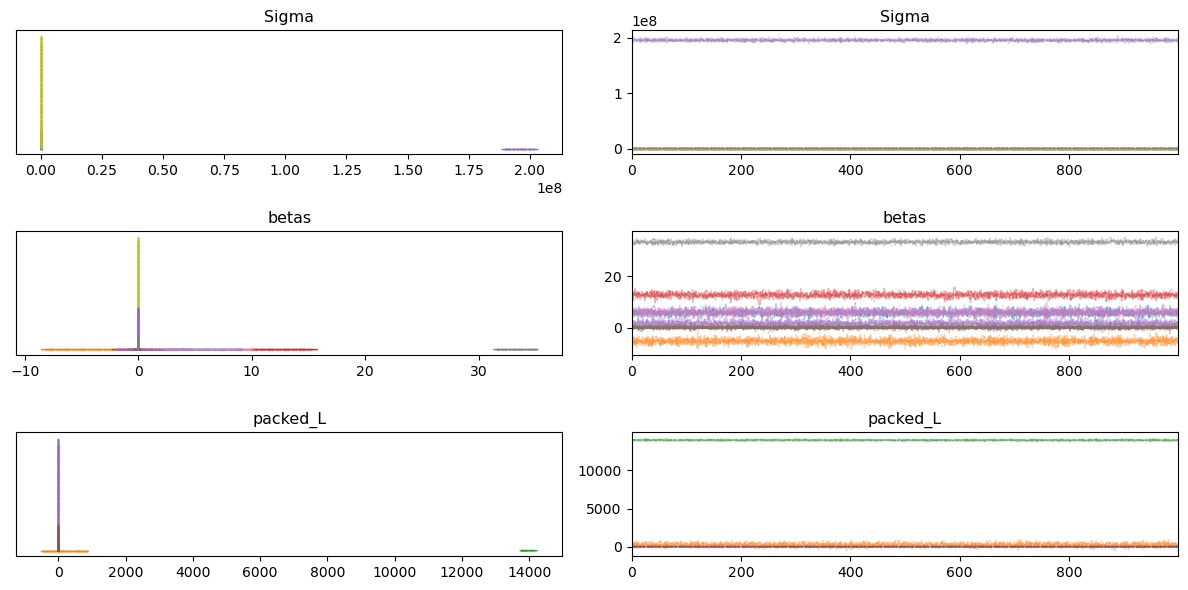

In [49]:
az.plot_trace(idata)
plt.tight_layout()
plt.show()

## Question 3

In [63]:
df = pd.read_csv("loan_data.csv").sample(500, random_state=1)
df = pd.get_dummies(df, columns=['person_gender'], drop_first=True, dtype=int)

In [64]:
df

,person_age,person_income,loan_amnt,loan_int_rate,loan_percent_income,credit_score,loan_status,person_gender_male
25275,33,100064,14400,16.00,0.14,696,0,1
12561,26,72861,12000,12.87,0.16,614,0,1
24707,28,83520,25000,19.41,0.30,675,1,1
25066,27,36977,12000,11.36,0.32,640,1,1
33429,23,94963,20000,13.45,0.21,648,0,1
...,...,...,...,...,...,...,...,...
36105,22,64241,10000,10.56,0.16,658,0,1
17812,25,55205,8000,10.38,0.14,637,0,0
41598,28,176284,14651,7.11,0.08,590,0,0
25236,35,54907,12000,11.26,0.22,681,0,0


In [67]:
X = df.drop(columns=['loan_status', 'person_gender_male']).values
Y = df[['loan_status', 'person_gender_male']].values

n,p = X.shape
m = Y.shape[1]

with pm.Model() as GLM:
    
    L,R,std = pm.LKJCholeskyCov("R", n=m, eta=2.0, 
                                sd_dist=pm.Exponential.dist(1.0, shape=m), 
                                compute_corr=True)

    betas = pm.Normal('betas', mu=0, sigma=1, shape=(p,m))

    z = pm.MvNormal('z', mu=X@betas, cov=R)

    y = pm.Bernoulli('y', p=pm.math.invprobit(z), observed=Y)   
    
    idata = pm.sample(step=pm.Metropolis())

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [R]
>Metropolis: [betas]
>Metropolis: [z]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 6252 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


In [68]:
az.summary(idata)

/opt/conda/lib/python3.11/site-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/opt/conda/lib/python3.11/site-packages/arviz/stats/diagnostics.py:991: RuntimeWarning: invalid value encountered in scalar divide
  varsd = varvar / evar / 4


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
R[0],1.019,1.046,0.001,2.922,0.032,0.037,755.0,637.0,1.00
R[1],-0.125,0.400,-0.863,0.411,0.087,0.125,28.0,36.0,1.25
R[2],1.088,1.030,0.015,3.232,0.303,0.232,11.0,26.0,1.31
"R_corr[0, 0]",1.000,0.000,1.000,1.000,0.000,NaN,4000.0,4000.0,NaN
"R_corr[0, 1]",-0.047,0.180,-0.386,0.275,0.038,0.014,23.0,62.0,1.16
...,...,...,...,...,...,...,...,...,...
"z[497, 1]",-0.686,0.843,-2.281,0.843,0.032,0.020,704.0,1035.0,1.01
"z[498, 0]",-1.061,0.873,-2.683,0.543,0.035,0.023,630.0,711.0,1.02
"z[498, 1]",-0.533,0.795,-2.060,0.920,0.027,0.017,848.0,1127.0,1.01
"z[499, 0]",-1.347,0.889,-3.169,0.165,0.036,0.019,610.0,970.0,1.01


/opt/conda/lib/python3.11/site-packages/arviz/stats/density_utils.py:488: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
/opt/conda/lib/python3.11/site-packages/arviz/stats/density_utils.py:700: RuntimeWarning: divide by zero encountered in divide
  f = grid_counts / bin_width / len(x)
/opt/conda/lib/python3.11/site-packages/arviz/stats/density_utils.py:700: RuntimeWarning: invalid value encountered in divide
  f = grid_counts / bin_width / len(x)
/opt/conda/lib/python3.11/site-packages/arviz/stats/density_utils.py:703: RuntimeWarning: divide by zero encountered in scalar divide
  bw /= bin_width


OverflowError: cannot convert float infinity to integer

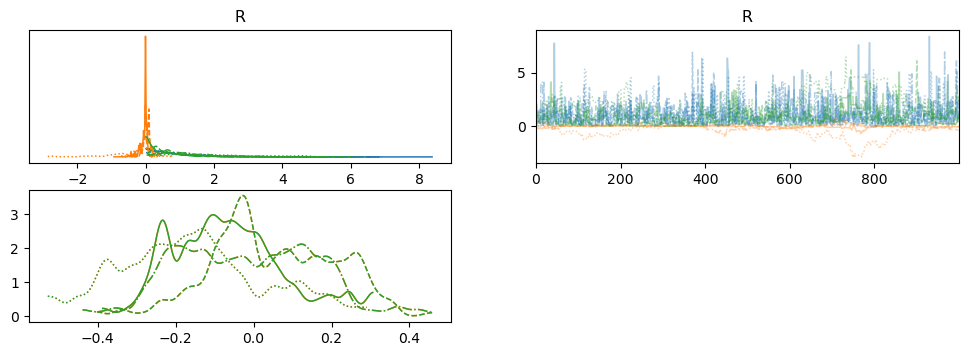

In [69]:
az.plot_trace(idata)
plt.tight_layout()
plt.show()